### PREDICTIVE SMILES TEXT GENERATOR

In [ ]:
# Imports (a little messy right now)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
%matplotlib inline

In [2]:
import csv
import nltk
import string
from google.colab import drive
from keras import backend as K
from keras.layers import Embedding
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import RDLogger
from queue import PriorityQueue
import queue

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.6 MB/s eta 0:00:00


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole # may be needed for viewing of molecules in notebook

<p>You start writing an email. You are tired of coming up with original phrases, so you begin:</p>
<p><code>I hope thi</code> <em>email finds you well</em></p>
<p>And gmail has predicted the exact phrase you were going to write... Predictive text is everywhere these days in emails, texts, even emojis in instant messaging systems.</p>
<p>Currently, every chemist "types" molecules by using drawing software, then coverts it to SMILES. But what if we were to reverse this process and have people type in SMILES and predict the molecules they were thinking of. We could create predictive text for the chemical keyboard!</p>

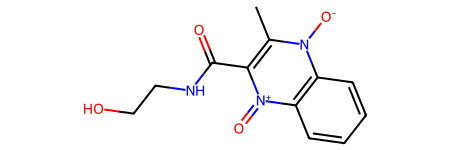

In [78]:
valid_smiles = 'OCCNC(c1c(n(c2c(cccc2)[n+]1=O)[O-])C)=O'
mol = Chem.MolFromSmiles(valid_smiles)
mol

In [ ]:
# we can get the canonical smiles like so
canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(valid_smiles))
canonical_smiles

'Cc1c(C(=O)NCCO)[n+](=O)c2ccccc2n1[O-]'

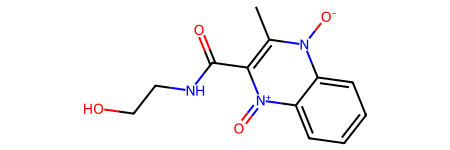

In [ ]:
# and it encodes the same molecule
mol2 = Chem.MolFromSmiles(canonical_smiles)
mol2

<p>Which is the same as the earlier molecule (though it is drawn a bit differently)</p>
<p>The goal here is for a user to start typing, then you should predict the next letter of the SMILES string, just like you might predict the next word of text in a classical NLP task. This by itself is not too crazy. But what you should also do is predict the smallest possible molecule it could be.</p>
<p>Let's say that I have so far typed</p>
<p><code>CC(</code></p>
<p>Then the following SMILES are all valid:</p>
<ul>
<li><code>CC(C)</code></li>
<li><code>CC(O)</code></li>
<li><code>CC(C)C</code></li>
<li><code>CC(C)O</code></li>
<li><code>CC(=O)</code></li>
<li><code>CC(C)CC</code></li>
</ul>
<p>and could represent the molecule I was thinking of with reasonable probability. Essentially, what I want is a feature that looks for molecules that are "likely to be" the molecule I am hoping to eventually type and are closeby my currently typed string. Obviously, if the ultimate string I am thinking of is <code>CC(N)C(=O)COCN(C)(CNC)</code>, then that is impossible to predict from <code>CC(</code>. However, it is still helpful if at every step the nearby molecules are predicted. </p>

In [ ]:
def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

In [ ]:
smi_tokenizer('OCCNC(c1c(n(c2c(cccc2)[n+]1=O)[O-])C)=O')

'O C C N C ( c 1 c ( n ( c 2 c ( c c c c 2 ) [n+] 1 = O ) [O-] ) C ) = O'

In [ ]:
smi_tokenizer('CCc1ccc')

'C C c 1 c c c'

In [6]:
df = pd.read_csv('SMILES_Keyboard.csv')
df = df.loc[df['SMILES'].str.len()<50][['SMILES', 'NAME']].reset_index(drop=True)
df.head()

,SMILES,NAME
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864


Preprocess Data:

1.   Extract SMILES strings from dataset
2.   Tokenize SMILES strings into individual chars and create dictionary
3.   Map characters to indices
4.   Convert SMILES strings into sequences of indices



In [7]:
# Basically what we want to do here if convert each SMILES string in the dataframe into a vector of numbers, where each
# number corresponds to the dictionary mapping of the letter.

# I am adding a letter that I know in advance is not in the word vocabulary to encode for end-of-phrase. Suspect?!
df['SMILES'] = df['SMILES'].astype(str) + 'E'

# Get all SMILES Strings (the data we want) into a list format for manipulation.
smiles = df['SMILES'].tolist()

# To create the vocabulary, we need each unique character seen thus far (list), then make it a set.
all_chars = set(''.join(smiles))

# List comprehension way of creating a char: index dictionary, sorted by ASCII. Reserve 0.
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Method to vectorize every smiles string.
def smiles_to_indices(smiles_string):
    return [char_to_idx[char] for char in smiles_string]

# Vectorize all smiles strings from original dataframe.
sequences = [smiles_to_indices(smiles_string) for smiles_string in smiles]

In [8]:
# N-padding for label creation. Didn't want size to get too excessive, but can train more later.
input_sequences = []
for vec in sequences:
  count = 0
  while(count < len(vec)):
    input_sequences.append(vec[:count+1])
    count += 1
len(input_sequences)

434816

In [9]:
# More concise way of writing the previous cell.
input_sequences = [vec[:count + 1] for vec in sequences[:5000] for count in range(len(vec))]
len(input_sequences)

183976

In [10]:
# Now we need to pad the data so that they are of the same length. We use pad_sequences to pad prior to tokens so that RNN will have 
# relevant token information before reaching final layer instead of 'forgetting' early info and getting a bunch of 0s instead.
max_seq_length = max([len(x) for x in input_sequences])
input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))
print(max_seq_length)

50


In [11]:
# X_values gets every element but last for each input, input_seqs gets last element for each input. This type of syntax works for arrays.
# We should also OHE the labels due to the nature of this problem as multi-classification.
x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels, num_classes=len(all_chars)+1)

In [60]:
# Now that we have the data, labels in the preferred format, we are almost ready to create the model. First, however, we must create word embeddings.
# This is important because:
#   1) Embeddings are more dense, especially compared to sparse OHE vectors.
#   2) Embeddings represent similar words similarly and different words differently--they capture relationships.
#   3) Embeddings reduce dimensionality, leading to less complexity. 
# Must figure out a way to use embeddings within the context of a smiles string, not just classic NLP.

# I have decided to let the Keras.Embedding layer handle this.

In [12]:
# Simple LSTM, room for improvement. Could incorporate bi-directionality.

# Keras.embedding documentation: Turns positive integers (indexes) into dense vectors of fixed size.
# e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

def lstm_model(vocab_size, padded_length, embedding_dim=128):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=padded_length))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    
    # Last layer should output probabilities for each letter in vocabulary.
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Could certainly train model for longer. This is mostly preliminary.
embedding_dim = 128
model = lstm_model(len(all_chars) + 1, 49, embedding_dim)
history = model.fit(x_values, y_values, epochs=20, batch_size=128)

In [71]:
def preprocess_input(input_str, vocab_dict, max_sequence_length):
    # Tokenize the input string into a sequence of integers--analogous to earlier procedure.
    input_sequence = [vocab_dict[char] for char in input_str if char in vocab_dict]
    
    # Pad/truncate the sequence to the maximum sequence length.
    if len(input_sequence) < max_sequence_length:
        input_sequence = [0] * (max_sequence_length - len(input_sequence)) + input_sequence
    else:
        input_sequence = input_sequence[:max_sequence_length]
    
    # Reshape the input sequence for the model.
    input_sequence = np.array(input_sequence).reshape(1, max_sequence_length)
    
    return input_sequence

In [15]:
# Method for check SMILES String validity. Due to the nature of error messages I have chosen to disable them.
def is_valid_smiles(smiles):
    RDLogger.DisableLog('rdApp.*')
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [63]:
# This method is where I implement a crude version of beam search--computationally very expensive because I am going through
# the top two predicted values without accounting for score down the tree, which scales with 2^n, n = branches.
# Though the problem right now is not very large, this can easily be fixed down the line taking into account a loss fn.
# This is also where the shortest potential strings will be outputted. 
def generate_smiles(model, initial_input, vocab_dict, inverse_vocab_dict, max_sequence_length, max_output_length=100):
    generated_smiles = initial_input
    
    # Get top 2 options from predictions. Could be a method argument.
    beam_width = 2
    valid_smiles = []
    
    # Initialize the queue in which the SMILES strings will reside. 
    seq_queue = queue.Queue()
    seq_queue.put(initial_input)
    
    stop_loop = False

    while not seq_queue.empty():
        if stop_loop:
          break
        
        # Take the first SMILES in the queue, process it, and put it in model.
        input_sequence = seq_queue.get()
        processed_input = preprocess_input(input_sequence, char_to_idx, 50)
        output_probabilities = model.predict(processed_input)

        # Get the top n possibilites, n = beam width.
        top_n = np.argpartition(output_probabilities.flatten(), -beam_width)[-beam_width:]
        for predicted_index in top_n:
        
          # Index -> char.
          predicted_char = inverse_vocab_dict[predicted_index]

          # Check if the predicted character is end token.
          if predicted_char == 'E':
            # break from this iteration
            break
        
          # Update input sequence.
          new_sequence = input_sequence + predicted_char

          # Check if current sequence yields a valid SMILES string. If so, add it to list. Check for length condition.
          if is_valid_smiles(new_sequence):
            valid_smiles.append(new_sequence)
          if len(valid_smiles) >= 5:
            stop_loop = True
            break
          
          seq_queue.put(new_sequence)

    return valid_smiles

In [ ]:
# Generate top 5 closest SMILES Strings based on user input. 
initial_input = "CCc1ccc"
generated_smiles = generate_smiles(model, initial_input, char_to_idx, idx_to_char, 49)

print("Generated SMILES:", generated_smiles)

In [77]:
Chem.MolFromSmiles(initial_input)

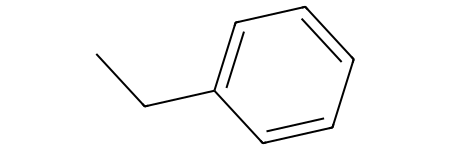

In [74]:
Chem.MolFromSmiles(generated_smiles[0])

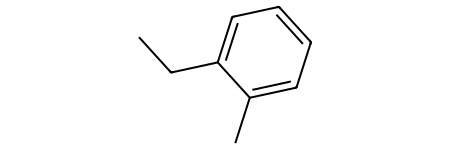

In [75]:
Chem.MolFromSmiles(generated_smiles[1])

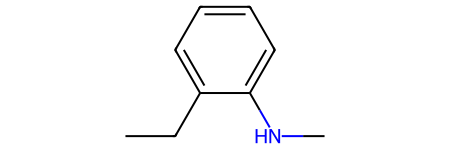

In [76]:
Chem.MolFromSmiles(generated_smiles[3])